# AI4CI Advanced Python Programming project
## Student: Molochko Ihnatii NTUU

In [1]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import folium

In [2]:
# Read the CSV file containing attack data into a DataFrame
df = pd.read_csv("attacks_database.csv")
df

,Start time,Attack Duration,Source IP,Attack Type,Total Packets,Total Bytes
0,2024-10-19 00:41:01,0.000409,83.233.54.239,Ping of Death,2,2084
1,2024-10-19 00:41:03,0.000518,103.186.33.118,SYN-ACK flood,2,114
2,2024-10-19 00:41:05,0.000380,192.168.150.129,Smurf,2,102
3,2024-10-19 00:41:07,0.000553,192.168.150.129,Smurf,2,102
4,2024-10-19 00:41:09,0.000381,5.171.220.236,Ping of Death,2,2084
...,...,...,...,...,...,...
1772,2024-10-19 01:40:54,0.000736,55.226.206.157,SYN-ACK flood,2,114
1773,2024-10-19 01:40:56,0.000582,169.218.175.247,SYN flood,2,114
1774,2024-10-19 01:40:58,0.000431,240.106.147.16,Ping of Death,2,2084
1775,2024-10-19 01:41:00,0.000386,185.114.25.81,SYN flood,2,114


# Task 1: Where are the suspect IP addresses located?

In [3]:
def get_location(ip):
    # Function to get the geographic location of an IP address using an external API
    url = f"http://ip-api.com/json/{ip}?fields=16593"
    try:
        response = requests.get(url)
        data = response.json()
        if data["status"] == "success":
            return data["lat"], data["lon"], data["city"], data["country"]
        else:
            return None, None, None, None
    except Exception as e:
        return None, None, None, None

In [4]:
# Apply the get_location function to the "Source IP" column and expand the results into new columns
df[["Latitude", "Longitude", "City", "Country"]] = df["Source IP"].apply(get_location).apply(pd.Series)

In [5]:
# Save the updated DataFrame with location data to a new CSV file
df.to_csv("attacks_database_with_locations.csv", index=False)

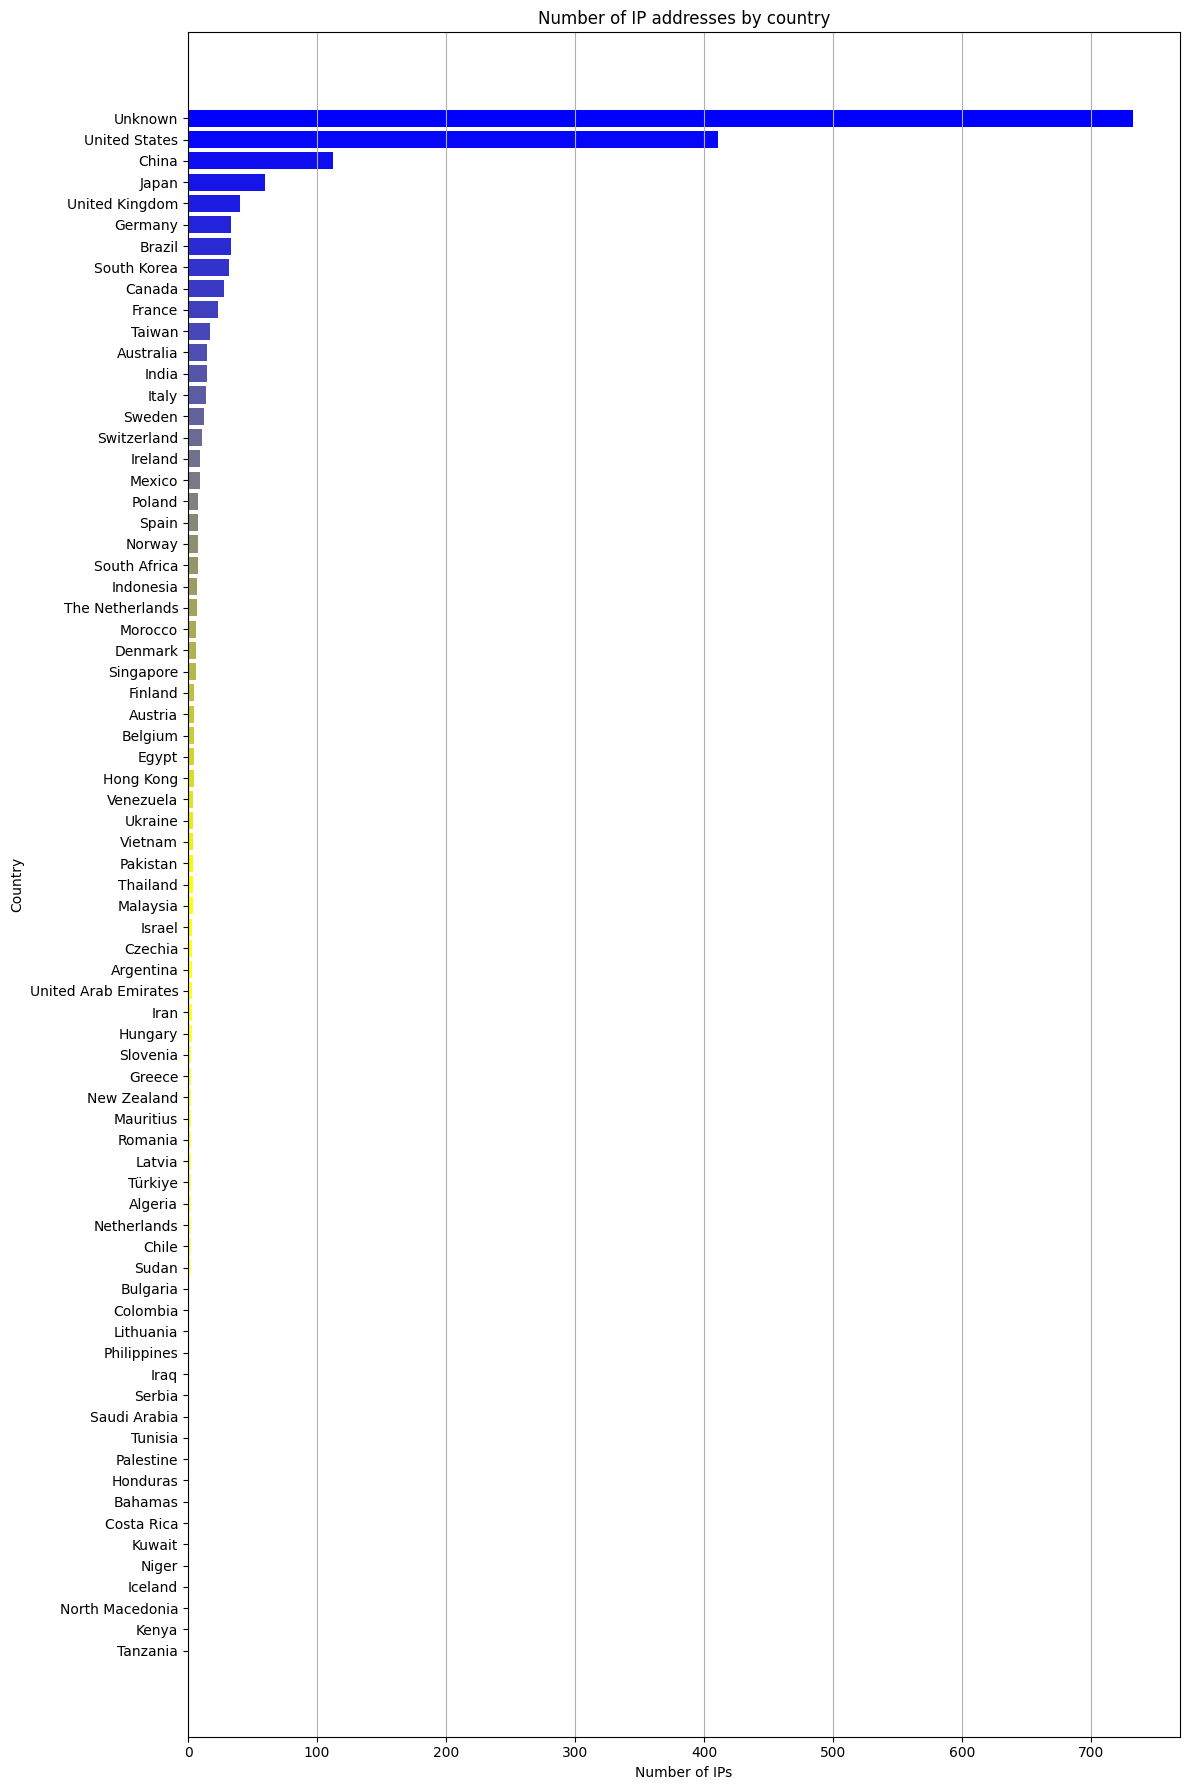

In [6]:
# Count the number of attacks per country and sort the results
country_counts = df["Country"].fillna("Unknown").value_counts().sort_values(ascending=True)

colors = ["blue", "yellow", "white"]
n = len(country_counts)
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=n)

gradient_colors = cmap(np.linspace(1, 0, n))

# Create a horizontal bar chart for the number of IP addresses by country
plt.figure(figsize=(12, 18))
plt.barh(country_counts.index, country_counts.values, color=gradient_colors, height=0.8)
plt.title("Number of IP addresses by country")
plt.xlabel("Number of IPs")
plt.ylabel("Country")
plt.grid(axis="x")
plt.tight_layout()

plt.show()  # Display the chart

In [7]:
# Filter the DataFrame to only include rows with non-null countries
filtered_df = df[df["Country"].notna()]

# Get unique Source IP addresses from the filtered DataFrame
unique_ips = filtered_df.drop_duplicates(subset=["Source IP"])
unique_ips

,Start time,Attack Duration,Source IP,Attack Type,Total Packets,Total Bytes,Latitude,Longitude,City,Country
0,2024-10-19 00:41:01,0.000409,83.233.54.239,Ping of Death,2,2084,57.737300,11.971400,Gothenburg,Sweden
1,2024-10-19 00:41:03,0.000518,103.186.33.118,SYN-ACK flood,2,114,0.555901,123.073000,Gorontalo,Indonesia
4,2024-10-19 00:41:09,0.000381,5.171.220.236,Ping of Death,2,2084,45.464200,9.189980,Milan,Italy
5,2024-10-19 00:41:11,0.000436,141.241.110.204,Ping of Death,2,2084,51.412600,-0.308600,Kingston upon Thames,United Kingdom
8,2024-10-19 00:41:17,0.000377,54.108.49.168,SYN-ACK flood,2,114,47.481500,-122.246000,Seattle,United States
...,...,...,...,...,...,...,...,...,...,...
1766,2024-10-19 01:40:42,0.000643,1.97.70.177,Ping of Death,2,2084,37.365400,127.122000,Seongnam-si,South Korea
1769,2024-10-19 01:40:48,0.000439,223.58.171.5,Ping of Death,2,2084,37.561000,126.995000,Seoul,South Korea
1772,2024-10-19 01:40:54,0.000736,55.226.206.157,SYN-ACK flood,2,114,31.555200,-110.350000,Sierra Vista,United States
1773,2024-10-19 01:40:56,0.000582,169.218.175.247,SYN flood,2,114,37.365400,127.122000,Seongnam-si,South Korea


In [8]:
# Create a Folium map centered at coordinates (0, 0) with an initial zoom level of 2
map = folium.Map(location=[0, 0], zoom_start=2)

In [9]:
# Add markers for each unique IP address on the map
for idx, row in unique_ips.iterrows():
    folium.Marker(
        location=(row["Latitude"], row["Longitude"]),
        popup=f"IP: {row['Source IP']}\nCity: {row['City']}\nCountry: {row['Country']}"
    ).add_to(map)

In [10]:
# Save the map to an HTML file
map.save("map.html")

map  # Display the map object (can be omitted in a script)

# Task 2: What is the attack that generated more packets?

In [11]:
# Group the DataFrame by "Attack Type" and sum the "Total Packets" for each type
packets_by_attack_type = df.groupby("Attack Type")["Total Packets"].sum()

# Find the attack type with the maximum number of packets
max_attack_type = packets_by_attack_type.idxmax()
max_packets = packets_by_attack_type.max()

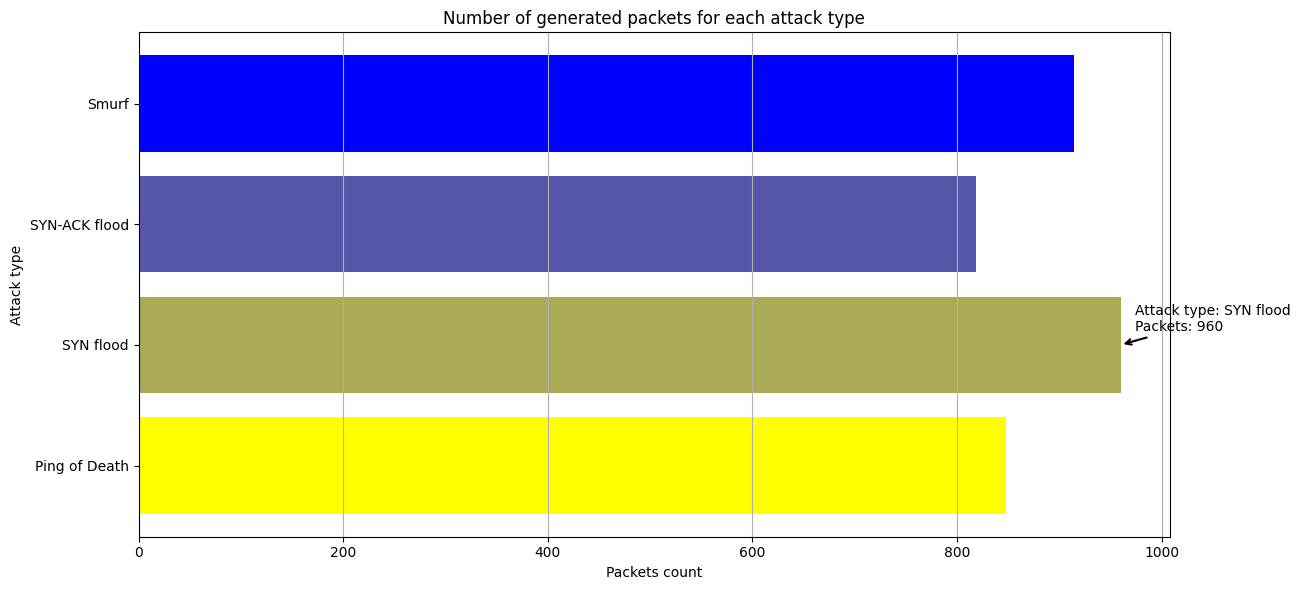

In [12]:
colors = ["blue", "yellow"]
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=4)

gradient_colors = cmap(np.linspace(1, 0, 4))

# Create a horizontal bar chart for the number of packets per attack type
plt.figure(figsize=(12, 6))
plt.barh(packets_by_attack_type.index, packets_by_attack_type.values, color=gradient_colors)
plt.title("Number of generated packets for each attack type")
plt.xlabel("Packets count")
plt.ylabel("Attack type")
plt.grid(axis="x")
plt.tight_layout()

plt.annotate(f"Attack type: {max_attack_type}\nPackets: {max_packets}",
             xy=(max_packets, packets_by_attack_type.index.get_loc(max_attack_type)),
             xytext=(10, 10),
             textcoords="offset points",
             arrowprops=dict(arrowstyle="->", lw=1.5))

plt.show()  # Display the chart

# Task 3.1: What is the attack that generated the largest traffic in terms of bytes?

In [13]:
# Group the DataFrame by "Attack Type" and sum the "Total Bytes" for each type
bytes_by_attack_type = df.groupby("Attack Type")["Total Bytes"].sum()

# Find the attack type with the maximum number of bytes
max_attack_type = bytes_by_attack_type.idxmax()
max_bytes = bytes_by_attack_type.max()

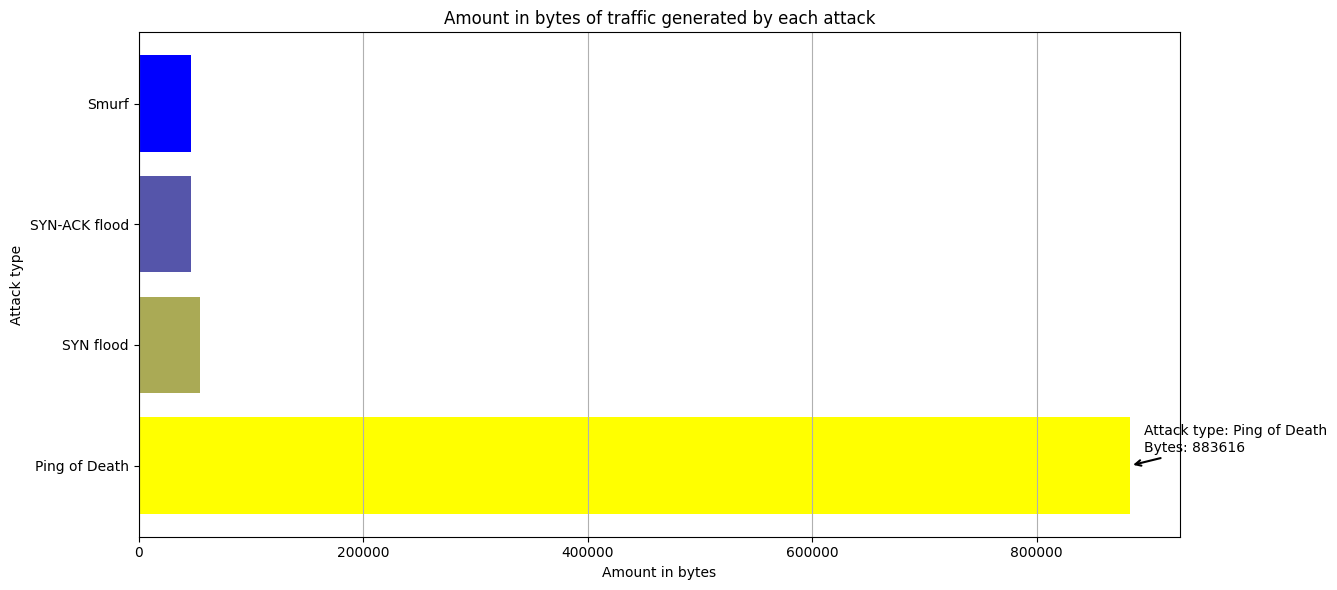

In [14]:
colors = ["blue", "yellow"]
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=4)

gradient_colors = cmap(np.linspace(1, 0, 4))

# Create a horizontal bar chart for the amount of bytes per attack type
plt.figure(figsize=(12, 6))
plt.barh(bytes_by_attack_type.index, bytes_by_attack_type.values, color=gradient_colors)
plt.title("Amount in bytes of traffic generated by each attack")
plt.xlabel("Amount in bytes")
plt.ylabel("Attack type")
plt.grid(axis="x")
plt.tight_layout()

plt.annotate(f"Attack type: {max_attack_type}\nBytes: {max_bytes}",
             xy=(max_bytes, bytes_by_attack_type.index.get_loc(max_attack_type)),
             xytext=(10, 10),
             textcoords="offset points",
             arrowprops=dict(arrowstyle="->", lw=1.5))

plt.show()  # Display the chart

# Task 3.2: What is the attack that generated the largest traffic in bytes per second?

In [15]:
# Convert "Attack Duration" to numeric values, coercing errors to NaN
df["Attack Duration"] = pd.to_numeric(df["Attack Duration"], errors="coerce")

# Calculate bytes per second by dividing total bytes by attack duration (replace 0s with NaN to avoid division errors)
df["Bytes per Second"] = df["Total Bytes"] / df["Attack Duration"].replace(0, float("nan"))

In [16]:
# Group the DataFrame by "Attack Type" and sum the "Bytes per Second" for each type
bps_by_attack_type = df.groupby("Attack Type")["Bytes per Second"].sum()

# Find the attack type with the maximum bytes per second
max_attack_type = bps_by_attack_type.idxmax()
max_bps = bps_by_attack_type.max()

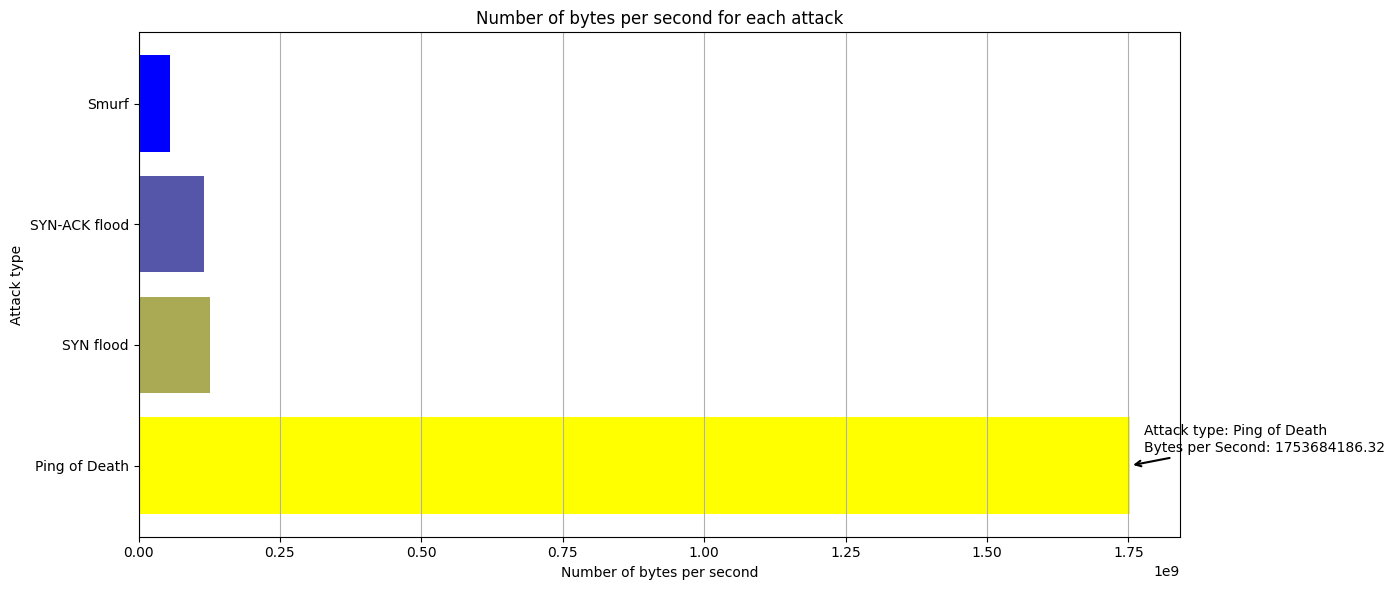

In [17]:
colors = ["blue", "yellow"]
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=4)

gradient_colors = cmap(np.linspace(1, 0, 4))

# Create a horizontal bar chart for the bytes per second per attack type
plt.figure(figsize=(12, 6))
plt.barh(bps_by_attack_type.index, bps_by_attack_type.values, color=gradient_colors)
plt.title("Number of bytes per second for each attack")
plt.xlabel("Number of bytes per second")
plt.ylabel("Attack type")
plt.grid(axis="x")
plt.tight_layout()

plt.annotate(f"Attack type: {max_attack_type}\nBytes per Second: {max_bps:.2f}",
             xy=(max_bps, bps_by_attack_type.index.get_loc(max_attack_type)),
             xytext=(10, 10),
             textcoords="offset points",
             arrowprops=dict(arrowstyle="->", lw=1.5))

plt.show()  # Display the chart